# Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical

In [ ]:
EPOCHS = 20
INIT_LR = 0.001
BS = 32
default_image_size = tuple((200, 200))
image_size = 0
directory_root = '/content/drive/MyDrive/Crop Disease/Image Data base'
width=224
height=224
depth=3
weight_decay = 0.0001
input_shape = (224,224,3)


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list,training_data,image_path = [], [],[],[]
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    dir = ''
    for plant_folder in root_dir :

        if plant_folder != 'Healthy':
          plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
          print(f"[INFO] Processing {plant_folder} ...")

          if len(plant_disease_folder_list) >= 200:
            for image in plant_disease_folder_list[:300]:

                image_directory = f'{directory_root}/{plant_folder}/{image}'
              
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                          # image_list.append(convert_image_to_array(image_directory))
                          label_list.append(plant_folder)
                          image_path.append(image_directory)
        

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing algal leaf in tea ...
[INFO] Processing anthracnose in tea ...
[INFO] Processing Apple Apple scab ...
[INFO] Processing Apple Black rot ...
[INFO] Processing Apple Cedar apple rust ...
[INFO] Processing Bacterial leaf blight in rice leaf ...
[INFO] Processing bird eye spot in tea ...
[INFO] Processing Blight in corn Leaf ...
[INFO] Processing brown blight in tea ...
[INFO] Processing Brown spot in rice leaf ...
[INFO] Processing cabbage looper ...
[INFO] Processing Cercospora leaf spot ...
[INFO] Processing Cherry (including sour) Powdery mildew ...
[INFO] Processing Common Rust in corn Leaf ...
[INFO] Processing Grape Black rot ...
[INFO] Processing Gray Leaf Spot in corn Leaf ...
[INFO] Processing lemon canker ...
[INFO] Processing Nitrogen deficiency in plant ...
[INFO] Processing potassium deficiency in plant ...
[INFO] Processing Potato Early blight ...
[INFO] Processing Potato Late blight ...
[INFO] Processing Sogatella rice ...
[INFO] 

In [ ]:
plant_folder = 'Healthy'
plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

  
for h_folder in plant_disease_folder_list[1:2]:

  h_dir = listdir(f'{directory_root}/{plant_folder}/{h_folder}')

  for image in h_dir[:300]:

    image_directory = f'{directory_root}/{plant_folder}/{h_folder}/{image}'
  
    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
              # image_list.append(convert_image_to_array(image_directory))
              label_list.append(plant_folder)
              image_path.append(image_directory)

In [ ]:
Fseries=pd.Series(image_path, name='filepaths')
Lseries=pd.Series(label_list, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)

In [ ]:
df

,filepaths,labels
0,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
1,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
2,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
3,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
4,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
...,...,...
6229,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy
6230,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy
6231,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy
6232,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy


# Data Augmentation

In [ ]:
Fseries=pd.Series(image_path, name='filepaths')
Lseries=pd.Series(label_list, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)

In [ ]:
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
# datagen = tf.keras.preprocessing.image.ImageDataGenerator()


train_gen=aug.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(height,width),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)

val_gen=aug.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(height,width),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)

test_gen=aug.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(height,width),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)


In [ ]:
len(train_df)

4987

In [ ]:
n_classes = len(train_gen[0][1][0])

In [ ]:
n_classes

21

In [ ]:
train_gen[0][0][0].shape

(224, 224, 3)

In [ ]:
# model = Sequential()
# inputShape = (height, width, depth)
# chanDim = -1
# if K.image_data_format() == "channels_first":
#     inputShape = (depth, height, width)
#     chanDim = 1
# model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Conv2D(64, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(128, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Conv2D(128, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(n_classes))
# model.add(Activation("softmax"))

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (3,3), padding = 'same' , activation = 'relu' , input_shape = input_shape))
# model.add(MaxPool2D(pool_size=(3,3) , strides = (2,2) , padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv2D(32 , (3,3), padding = 'same' , activation = 'relu', input_shape = input_shape))
# model.add(MaxPool2D(pool_size = (3,3) , strides = (2,2) , padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv2D(64 , (2,2), padding = 'same' , activation = 'relu', input_shape = input_shape))
# model.add(MaxPool2D(pool_size = (2,2) , strides = (2,2) , padding = 'same'))
# model.add(BatchNormalization())


# model.add(Flatten())
# model.add(Dense(units = 64 , activation = 'relu'))
# model.add(Dropout(0.4))
# model.add(Dense(units = n_classes , activation = 'softmax'))

# CNN Model Construction

In [ ]:
inputShape = (224, 224, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Model Compilation
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=3)

# Model Training
history = model.fit(train_gen, epochs=EPOCHS,validation_data=val_gen, callbacks=[early_stopping])

In [ ]:
pip install visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 12.3 MB/s eta 0:00:00


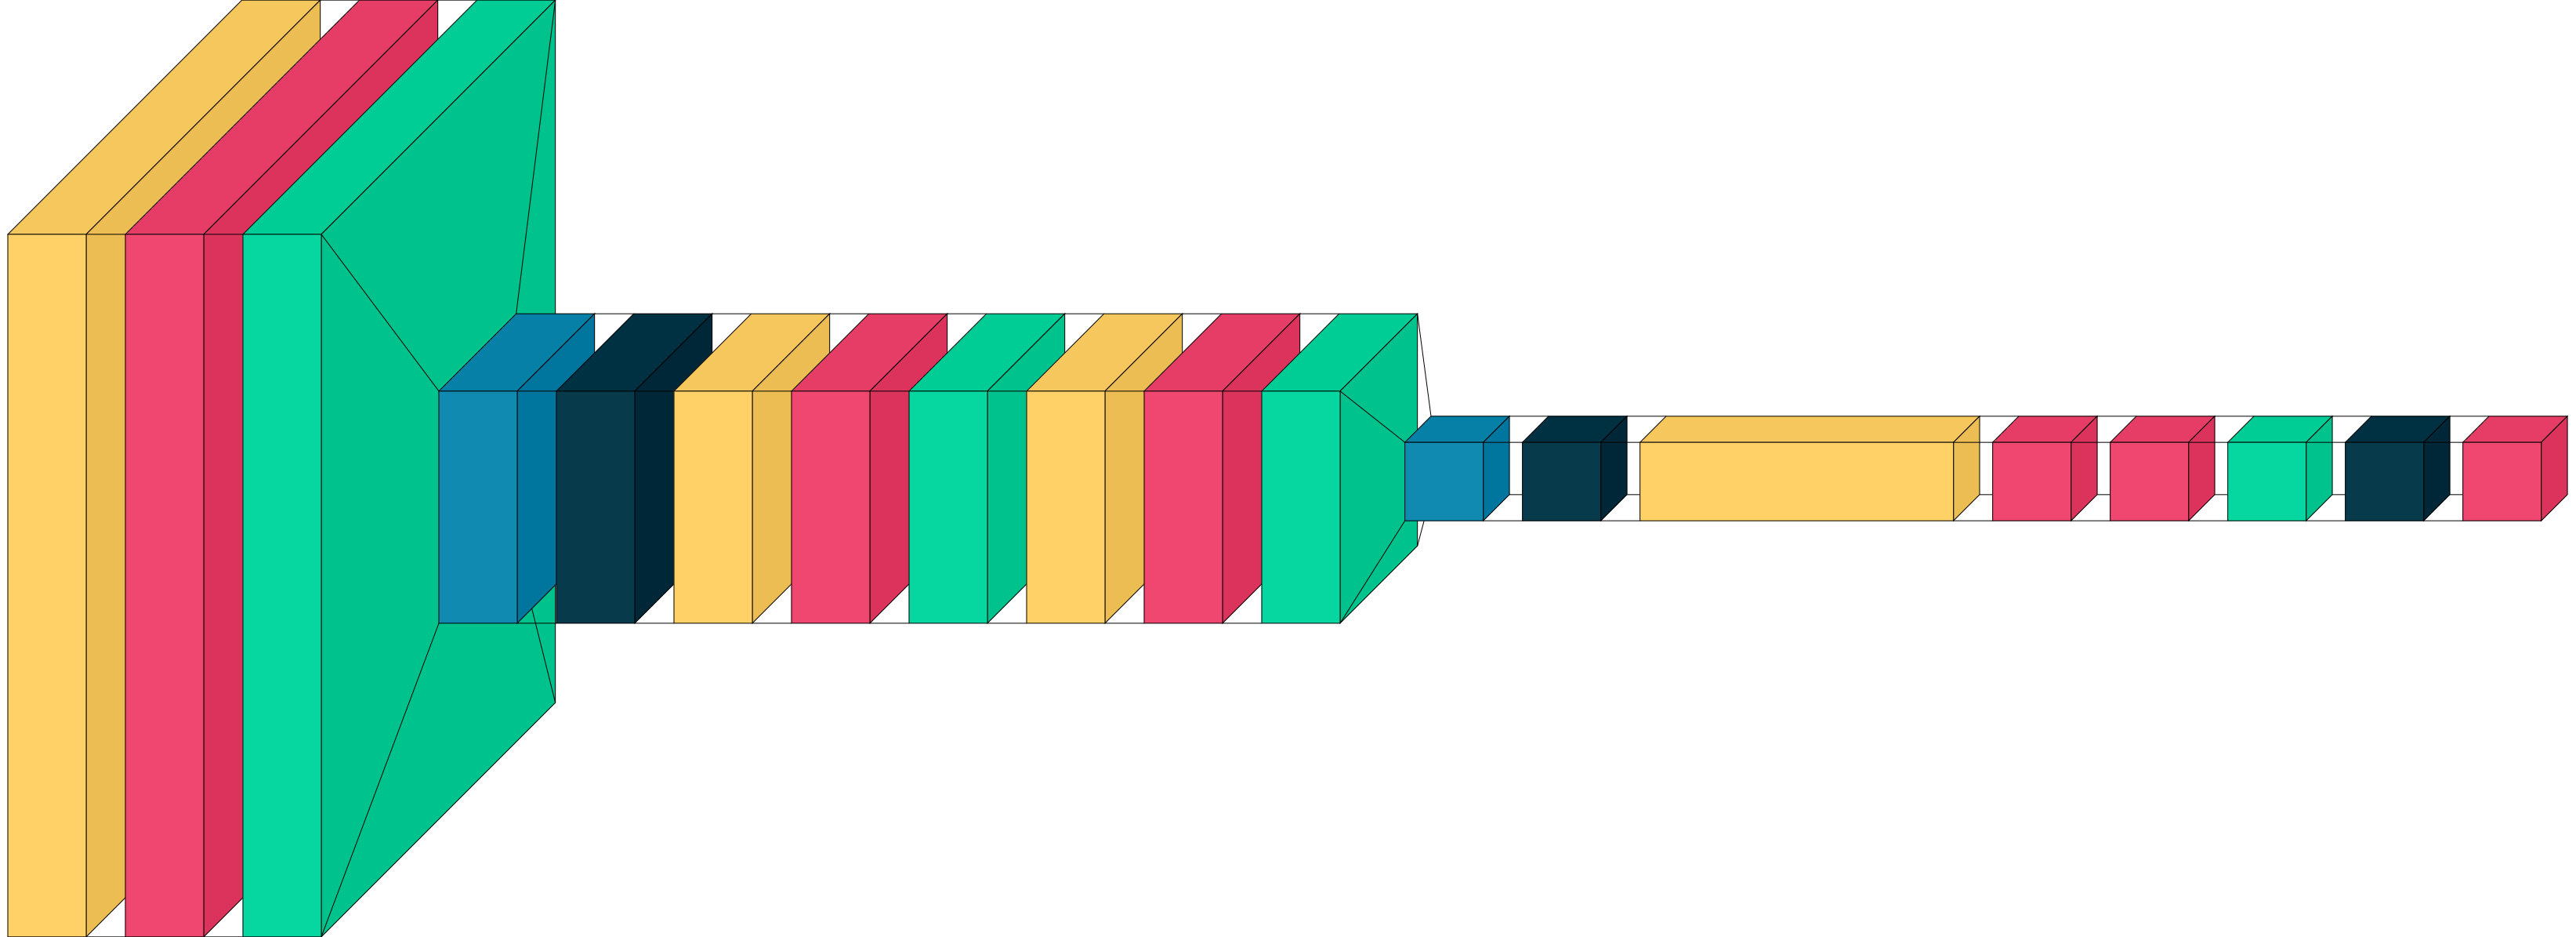

In [ ]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model,legend=False,spacing=50, min_xy = 100, min_z=100) 



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     896       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 74, 74, 64)       

In [ ]:
score = model.evaluate(test_gen)

20/20 [==============================] - 180s 9s/step - loss: 0.7387 - accuracy: 0.7692


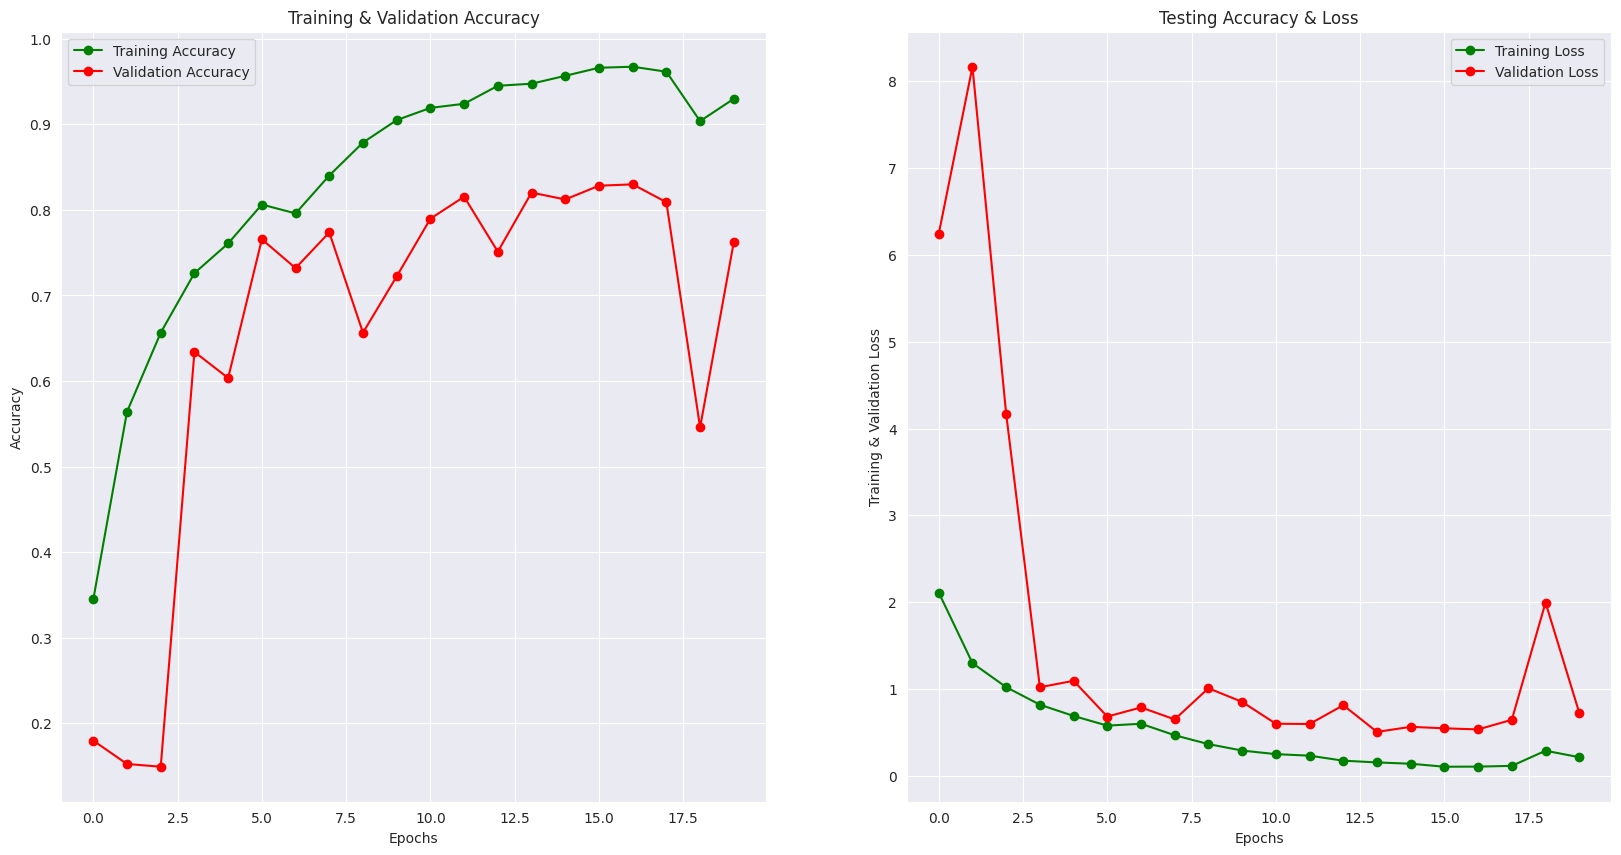

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
model_json = model.to_json()
with open("CNNmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNNmodel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
probs = model.predict(test_gen, steps=20, verbose=1)


20/20 [==============================] - 43s 2s/step


In [ ]:
test_gen.n

624

In [ ]:
pred_label = np.argmax(probs, axis=1)


In [ ]:
pred_label

array([ 2,  5, 10, 17, 16, 14, 11, 17, 14,  8,  7,  8, 19, 19,  6, 18,  2,
       11,  5,  7,  2, 10, 12, 19,  2, 20, 19,  2,  6,  1, 20,  5,  7, 14,
        4, 19, 19, 15,  9, 14, 11, 14,  6, 16, 17,  3, 11, 10,  3, 19, 17,
        9,  4, 13, 19, 14,  2,  7, 11, 12,  2, 14, 11,  7, 14, 14, 19,  1,
       18,  9,  7,  2, 11, 10, 11, 19,  2, 17,  6,  8,  5,  7,  5, 10,  2,
        1, 10,  6, 16, 19, 14,  7, 14, 11, 16,  6, 15,  5, 13,  5,  5, 14,
        4, 12,  2,  7, 16,  0,  7, 13, 14, 20,  2,  7,  9,  6,  8, 14,  3,
       11, 15,  0, 16, 14, 17,  6, 15,  6, 15,  7,  5,  2, 10, 10,  9, 19,
        2, 17,  9,  6, 16, 17,  2, 19, 16, 17,  4,  0, 17, 13, 15, 19,  7,
        1,  3, 13, 11, 10,  5,  6,  9, 10, 11, 11, 16,  6,  7, 18, 15,  4,
        8, 11,  8, 16, 10,  5, 11,  1, 18, 14,  2,  9, 15,  7, 17,  8, 17,
        7, 20,  6,  5, 18,  4,  7, 15,  3,  6, 14, 11,  0,  4, 16,  0, 18,
       19, 20,  5,  4,  2,  5, 19,  5,  9, 18,  3, 13,  2, 14,  5,  6, 10,
        2, 20,  2,  1, 10

In [ ]:
classes = set(label_list)

In [ ]:
classes

{'Apple Apple scab',
 'Apple Black rot',
 'Apple Cedar apple rust',
 'Blight in corn Leaf',
 'Cherry (including sour) Powdery mildew',
 'Common Rust in corn Leaf',
 'Grape Black rot',
 'Gray Leaf Spot in corn Leaf',
 'Healthy',
 'Potato Early blight',
 'Potato Late blight',
 'Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Target Spot',
 'algal leaf in tea',
 'anthracnose in tea',
 'bird eye spot in tea',
 'brown blight in tea',
 'cabbage looper'}

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_gen.classes, pred_label, target_names = classes))

                                             precision    recall  f1-score   support

     Cherry (including sour) Powdery mildew       0.14      0.13      0.14        30
                         anthracnose in tea       0.04      0.03      0.04        30
                         Potato Late blight       0.10      0.17      0.13        30
                         Tomato Target Spot       0.09      0.07      0.08        30
                            Apple Black rot       0.00      0.00      0.00        30
                        Tomato Early blight       0.03      0.03      0.03        30
                             cabbage looper       0.13      0.13      0.13        30
                Gray Leaf Spot in corn Leaf       0.00      0.00      0.00        30
                      Tomato Bacterial spot       0.00      0.00      0.00        30
                     Apple Cedar apple rust       0.03      0.03      0.03        30
                  Tomato Septoria leaf spot       0.00      0.00